<a href="https://colab.research.google.com/github/laxmimurali/Adversarial/blob/main/AdversarialNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adversarial Noise

**Import standard libraries**

In [17]:
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image
from fastai.vision.all import *
import shutil

# Visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm.notebook import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

# Torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

**Fetching the device that will be used throughout this notebook.**




In [18]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


**Load the CNN pretrained on ImageNet**

In [19]:
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.eval()  # cuda preferable
for p in resnet50.parameters():
    p.requires_grad = False

resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Mean and Std from ImageNet**

In [5]:
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

**Preprocess data**

In [6]:
preprocess = transforms.Compose([transforms.Resize(256), # cuts out edges
                                 transforms.CenterCrop(224),  # then crop
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=NORM_MEAN,
                                                      std=NORM_STD)
                                 ])

**Load data**

In [7]:
from torchvision.datasets.utils import download_url
dataset_url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
db = download_url(dataset_url,'.')


100%|██████████| 661378/661378 [00:00<00:00, 13944075.27it/s]


**Preprocess the data and add batch dimensions**

In [8]:
input_image = Image.open(filename)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)

**Convert tensor into a variable**

In [9]:
input_variable = input_batch.clone().detach().requires_grad_(True)

**Download ImageNet labels**


In [10]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-06-07 22:01:16--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-06-07 22:01:16 (87.0 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



**Classify the input using the resnet50 model and calculate the probability distribution over all the classes using softmax function**

In [11]:
def eval(img, model):
  with torch.no_grad():
      output = model(img)
      #print(output[0])
  probabilities = F.softmax(output[0], dim=0)
  #print(probabilities)
  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())
  x_label = top5_catid[0]
  x_pred = categories[top5_catid[0]]
  x_pred_prob = top5_prob[0].item()
  return(x_label,x_pred, x_pred_prob)

In [12]:
x_label, x_pred, x_pred_prob = eval(input_batch, resnet50)

Samoyed 0.8732958436012268
Pomeranian 0.03027082234621048
white wolf 0.019671205431222916
keeshond 0.011073519475758076
Eskimo dog 0.00920427218079567


##Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by Ian Goodfellow et al. in 2014. Given an image, we create an adversarial example by the following expression:

$X^{adv} = X + ϵsign(\nabla_x J(X, Y_{true})$

$X$ : input
$X^{adv}$ : adversarial input
$ϵ$ : magnitude of adversarial perturbation
$\nabla_x J(X, Y_{true})$ : gradient of loss function wrt to input

Resembles SGD

Change input in the direction of maximising the loss



In [14]:
def FGSM(model, img, label, epsilon):
  out = model(img) #img needs to be variable

  y_true = label
  target = torch.tensor(torch.LongTensor([y_true]), requires_grad=False)
  print(target)

  # Calculate loss by NLL
  #loss = torch.nn.CrossEntropyLoss()
  loss = -torch.gather(out, 1, target.to(device).unsqueeze(dim=-1))
  loss.sum().backward() #calculate gradients of each variable(with requires_grad=True)
  # Update image to adversarial example as written above
  noise_grad = torch.sign(input_variable.grad.data.to(device)) #calc sign
  x_adv = input_variable.data + epsilon * noise_grad #find adv using formula
  output_adv = resnet50.forward(torch.tensor(x_adv)) #forward pass on adv
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  x_adv_pred = categories[torch.max(output_adv.data,1)[1][0]]
  adv_probs = F.softmax(output_adv[0], dim=0) #prob distribution over classes
  top5_adv_prob, top5_adv_catid = torch.topk(adv_probs, 5)
  for i in range(top5_adv_prob.size(0)):
      print(categories[top5_adv_catid[i]], top5_adv_prob[i].item())
  adv_pred_prob = top5_adv_prob[0].item()
  return(noise_grad, x_adv, x_adv_pred, adv_pred_prob)

epsilon = 0.07
noise_grad, x_adv, x_adv_pred, adv_pred_prob = FGSM(resnet50, input_variable, x_label, epsilon)

<ipython-input-14-81f52723da44>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(torch.LongTensor([y_true]), requires_grad=False)


tensor([258])


<ipython-input-14-81f52723da44>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_adv = resnet50.forward(torch.tensor(x_adv)) #forward pass on adv


West Highland white terrier 0.5610276460647583
Scotch terrier 0.0578097328543663
wallaby 0.04779668524861336
cairn 0.040056291967630386
Angora 0.02734329365193844


**Visualization**

In [15]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):

    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(NORM_STD).view(3,1,1)).add(torch.FloatTensor(NORM_MEAN).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)

    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(NORM_STD).view(3,1,1)).add(torch.FloatTensor(NORM_MEAN).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)

    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)

    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Input', fontsize=20)


    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])


    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial example', fontsize=20)

    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center",
             transform=ax[0].transAxes)

    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob*100), size=15, ha="center",
         transform=ax[0].transAxes)

    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob*100), size=15, ha="center",
         transform=ax[2].transAxes)


    plt.show()

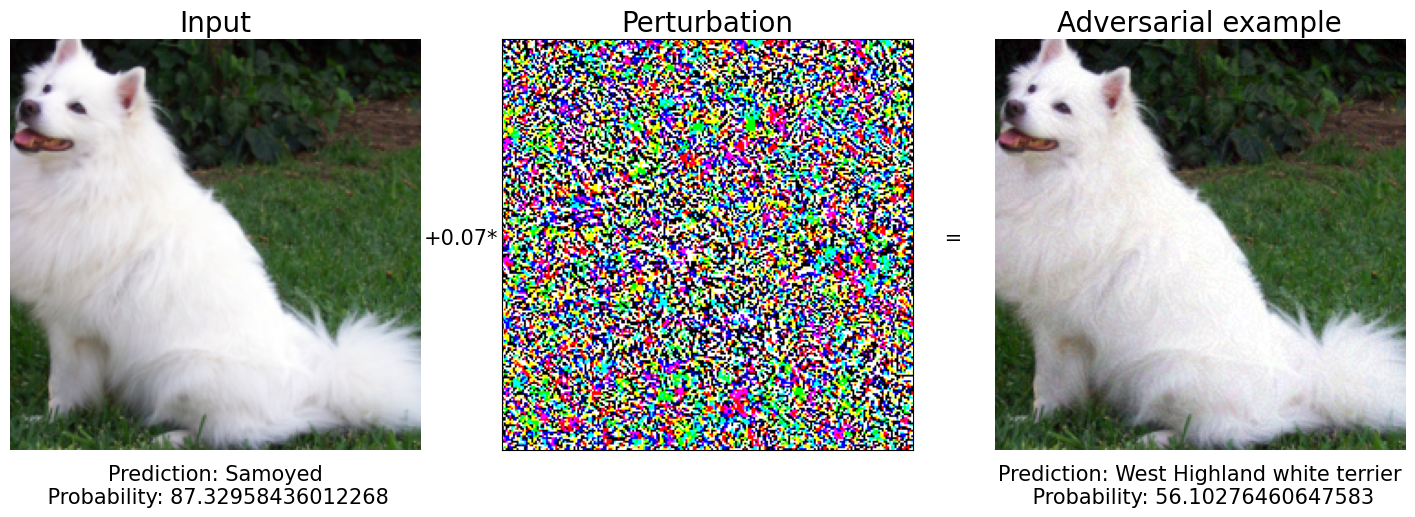

In [16]:
visualize(input_tensor, x_adv, noise_grad, epsilon, x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)